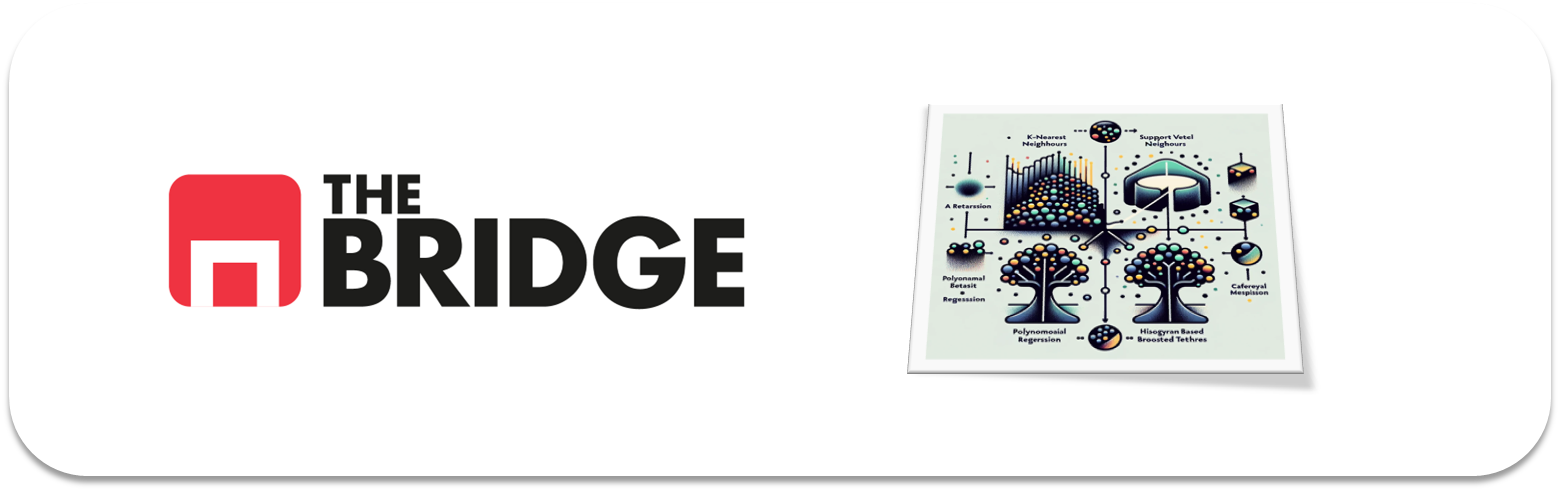

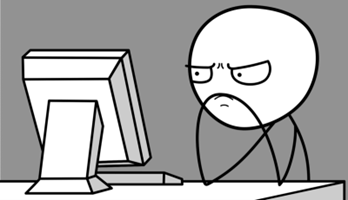

Para hacer un **repaso a los problemas de regresión con ML**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### INTRODUCCIóN: PROCESO DE ML

En los siguientes ejercicios vamos a seguir (de nuevo) los pasos básicos en la creación de un modelo de ML para resolver un problema de predicción a partir de un dataset que incluye el target, es decir, un aprendizaje supervisado.

En concreto, vamos a trabajar sobre un problema de clasificación a través de los siguientes pasos:

1. Entendimiento del problema (selección de la métrica más adecuada)  
2. Obtención de datos y primer contacto  
3. Train y Test  
4. MiniEDA: Análisis del target, análisis bivariante, entendimiento de las features, selección de las mismas (si es necesario)  
5. Preparación del dataset de Train: Conversión de categóricas, tratamiento de numéricas  
6. Selección e instanciación de modelos. Baseline.
7. Comparación de modelos (lo haremos por comparación con validación, puedes hacerlo por comparación de modelos de hiperparámetros optimizados, si así lo prefieres)  
8. Selección de modelo: Optimización de hiperparámetros (ten en cuenta la nota de 7)  
9. Evaluación contra test.  
10. Análisis de errores, posibles acciones futuras.  
11. EXTRA: Persistencia del modelo en disco.  

### El problema de Negocio

El ayuntamiento de Freehold, Nueva Jersey, está preocupado por los niveles de Ozono en situaciones de contaminación. Ha adquirido unos sensores muy potentes que permiten medir la composición de la calidad del aire casi en tiempo real, pero desgraciadamente la medida de Ozono se obtiene mucho más tarde (casi 12 horas después, este dato de las horas no es relevante para el problema). Las medidas son enviadas a una plataforma central donde se quiere incorporar un modelo que en función de esas medidas pueda predecir el nivel de $O_3$ (Ozono) en el aire y establecer alarmas y umbrales para avisar a la población o tomar medidas si es necesaria.

El concejal de urbanismo y tecnología, Bruce S., os contrata para que creéis ese modelo y para ello os suministra un dataset con medidas de la calidad de aire donde han incorporado el nivel de Ozono ("PT08.S5(O3)") posteriormente. Quieren un modelo que se equivoque en media en menos de 100 unidades por millón (la medida en la que tienen registrada la presencia de Ozono).

¡Manos a la obra!

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from toolbox_ML import *

### Ejercicio 1: Entendiendo el problema de "Negocio"

En función de la descripción del problema de "negocio" y sin mirar todavía los datos, ¿qué métricas creess más conveniente para medir el rendimiento del modelo a construir y, por tanto, para comparar posibles modelos entre sí?

*La Raíz del Error Cuadrático Medio (RMSE), ya que penaliza grandes errores y se da en la misma unidad que la variable objetivo*

### Ejercicio 2: Obtención y primer "vistazo"

Carga el dataset, muestra sus primeras filas, su descripción general y determina el tipo de variables que vamos a manejar. Escoge el target y crea una variable `target` y asignalé el nombre de la columna correspondiente.

In [2]:
df = pd.read_csv('./data/air_contamination.csv')
df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [3]:
describe_df(df).T

,,,,
COL_N,DATA_TYPE,MISSINGS (%),UNIQUE_VALUES,CARDIN (%)
CO(GT),float64,0.0,95,1.06
PT08.S1(CO),float64,0.0,3245,36.09
NMHC(GT),int64,0.0,428,4.76
C6H6(GT),float64,0.0,3772,41.95
PT08.S2(NMHC),float64,0.0,3772,41.95
NOx(GT),float64,0.0,2362,26.27
PT08.S3(NOx),float64,0.0,3518,39.13
NO2(GT),float64,0.0,1367,15.2
PT08.S4(NO2),float64,0.0,4407,49.02


In [4]:
target = 'PT08.S5(O3)'

*Dataset limpio con variables numéricas continuas, teniendo 93 valores únicos la variable con menor cardinalidad*

### Ejercicio 3: Split

Haz el split en train y test.

In [5]:
set_train, set_test = train_test_split(df, test_size=0.2, random_state=42)

### Ejercicio 4: MiniEDA (I)

Analiza la distribución del target brevemente.

<Axes: >

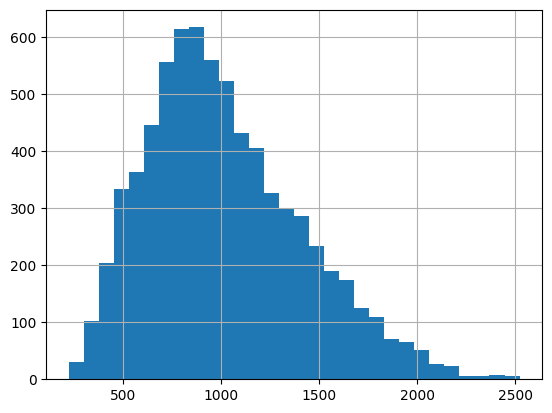

In [6]:
set_train[target].hist(bins=30)

*Podríamos aplicarle un logaritmo, aunque no está muy descentrado*

### Ejercicio 5: MiniEDA (II)

Analiza bivariantemente las variables contra el target, para las numéricas analiza la correlación numéricamente y gráficamente, para las categóricas analiza la distribución del target para cada valor de la categórica.

<Axes: >

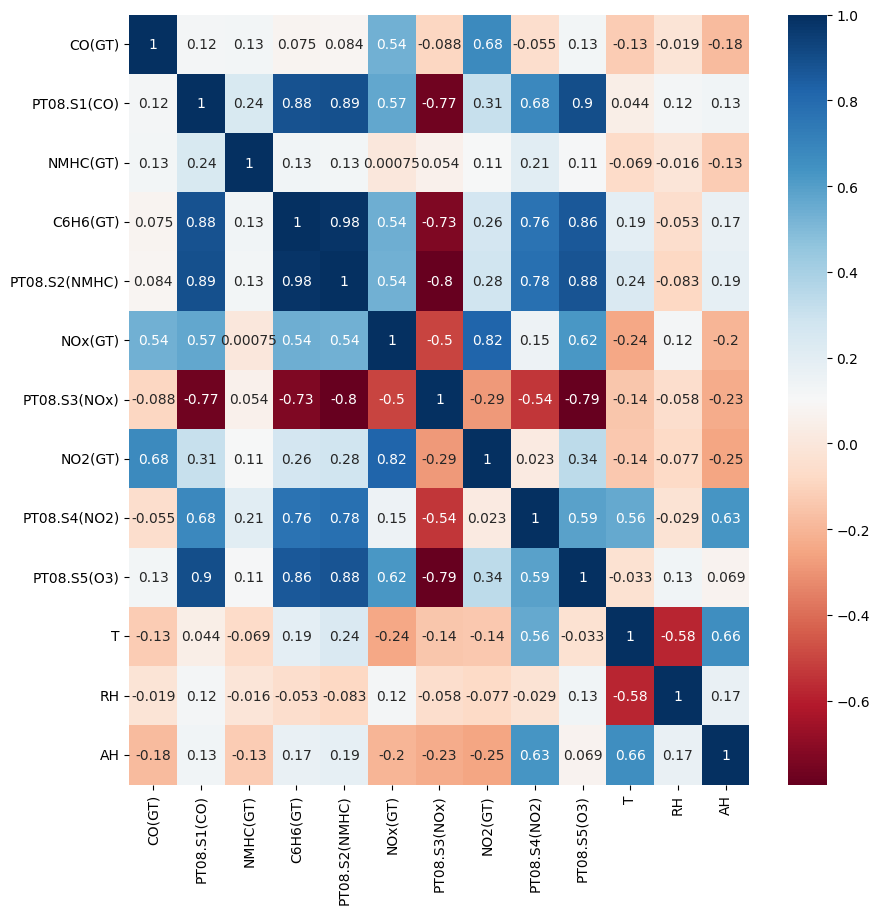

In [7]:
# Anaizamos con una matriz de correlación aplicando un heatmap,
# en dónde se destacan las colerraciones positivas en azul y las negativas en rojo
# Para el caso de nuestro target, vemos que 7 variables correlacionan por encima de 0.3

plt.subplots(1,1, figsize=(10,10))
sns.heatmap(set_train.corr(), annot=True, cmap='RdBu')

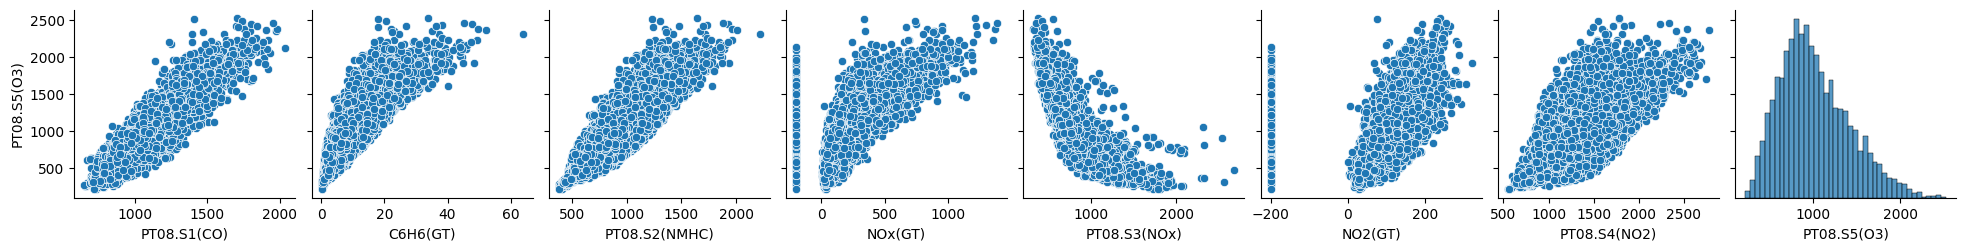

In [8]:
# Comprobamos visualmente como se correlacionan con el target las variables con un umbral de correlación > 0.3
# Observamos que tenemos valores negativos en NOx y NO2

plot_features_num_regression(set_train, target_col = target, columns=[], umbral_corr=0.3)

In [9]:
# Ahora sacamos la lista de features que correlacionan > 0.3 
# y comprobamos si alguna de estas features se correlacionan entre ellas

features_num = get_features_num_regression(set_train, target_col=target, umbral_corr=0.3)

for feature in features_num:
    lista = get_features_num_regression(set_train, target_col=feature, umbral_corr=0.9)
    if len(lista) > 0:
        print(f'{feature} correlaciona a >0.9 con: \t{','.join(lista)}')

PT08.S1(CO) correlaciona a >0.9 con: 	PT08.S5(O3)
C6H6(GT) correlaciona a >0.9 con: 	PT08.S2(NMHC)
PT08.S2(NMHC) correlaciona a >0.9 con: 	C6H6(GT)


In [10]:
# Vemos que C6H6(GT) y PT08.S2(NMHC) correlacionan un 0.98 (son equivalentes),
# por lo que descartaremos la que menor correlación tenga con el target,
# en este caso C6H6 correlaciona dos puntos menos (0.86 frente a 0.88)

features_num.remove('C6H6(GT)')
features_num

['PT08.S1(CO)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)']

In [11]:
# Comprobamos números negativos en las variables seleccionadas (valores nulos)

for feature in features_num:
    num_neg = set_train.loc[set_train[feature] < 0, feature].count()
    if num_neg > 0:
        print(f'{feature}: {num_neg} de {len(set_train)} - {round(num_neg/len(set_train)*100, 2)} %')

NOx(GT): 1283 de 7192 - 17.84 %
NO2(GT): 1286 de 7192 - 17.88 %


In [12]:
# Revisando las correlaciones vemos que NO2(GT) y NOx(GT) correlacionan en un 0.82,
# por tanto eliminaremos la variable que menos correlacione con nuestro target, 
# en este caso, NO2(GT) correlaciona un 0.32 frente a 0.63 de NOx(GT)

features_num.remove('NO2(GT)')
features_num

['PT08.S1(CO)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'PT08.S4(NO2)']

### Ejercicio 6: MiniEDA (III)

Crea una variable de tipo lista a la que asignes los valores de las columnas que creas conveniente emplear como features en función de lo visto en el miniEDA. Haz una lista de modelos/algoritmos que vas a emplear para hacer el modelo (solo los nombres). En función de la lista anterior, ¿tienes que tratar las variables, por qué?

*Valorndo las gráficas de dispersión entre las features y el target podemos ver que a niveles altos, el ozono se estabiliza en forma de curva logarítmica. Si bien los niveles inferiores en la mayoría de casos siguen una línea recta, en algunas features, como CO, NMHC, NO2 y de forma negativa con NOx, siguen una curva. Por tanto, lo que buscamos es una función polinómica, y por ello, usaremos los siguientes modelos:*  
> KNN  
> RandomForest  
> XGBoost  

*Para el caso de los dos primeros será necesario escalar los datos*

### Ejercicio 7: Tratamiento de features

Trata las features de manera que puedan ser empleadas por los modelos que escogite en el ejercicio anterior. Recuerda que este es un paso necesario porque los modelos no entienden de primeras de "letras" (salvo alguno que no es que entienda sino que hace sus transformaciones por dentro) y porque en determinados algoritmos es necesario que los rangos de las features estén escalados para que el algoritmo no se decante (érroneamente) por alguna feature sólo porque sus valores son mayores en rango que el de otras. NOTA: Recuerda que lo que le hagas al train, se lo tienes que hacer al test

In [13]:
# Primero reemplazamos los valores negativos (-200) por nulos de NOx(GT), la única variable seleccionada con 'nulos'

set_train.loc[set_train['NOx(GT)'] < 0, 'NOx(GT)'] = np.nan
set_test.loc[set_test['NOx(GT)'] < 0, 'NOx(GT)'] = np.nan

# Ahora imputamos usando KNN, para ello debermos escalar primero,
# y para hacer todo esto nos apoyamo en un pipeline

pipeline = Pipeline([('scaler', StandardScaler()), ('imputer', KNNImputer())])

X_train_knn = pd.DataFrame(pipeline.fit_transform(set_train[features_num]), columns=features_num, index=set_train.index)
X_test_knn = pd.DataFrame(pipeline.transform(set_test[features_num]), columns=features_num, index=set_test.index)

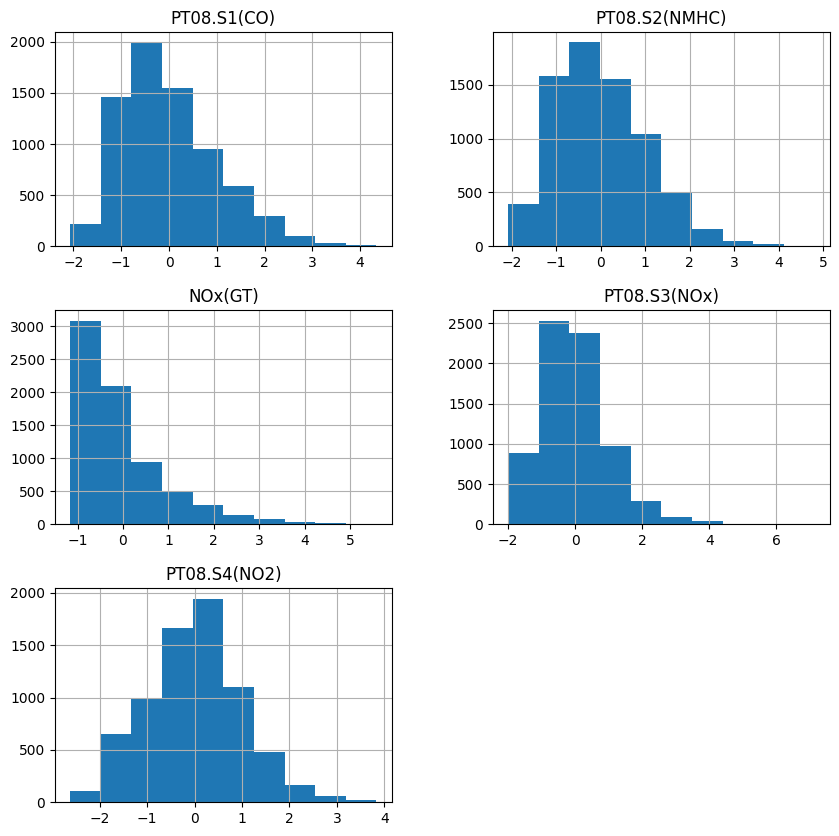

In [14]:
# Comprobamos las distribuciones escaladas

X_train_knn.hist(figsize=(10,10));

### Ejercicio 8: Creación de los dataset de train y test

Crea las parejas X,y de train y test.

In [15]:
X_train = set_train[features_num]
y_train = set_train[target]

X_test = set_test[features_num]
y_test = set_test[target]

### Ejercicios 9:

Importa e instancia los modelos que hayas escogido en el ejercicio 6. En general, no hace falta que asignes ahora ningún hiperparámetro salvo en los basados en árboles en los que debes escoger un max_depth para evitar el sobreajuste inicial. 

In [16]:
knn = KNeighborsRegressor(n_neighbors=5)                        # Valor por defecto
rf_reg = RandomForestRegressor(max_depth=5, random_state=42)    # Asignamos random_state para comparar mejor
xgb = XGBRegressor(max_depth=5, random_state=42)                # Asignamos random_state para comparar mejor

### Ejercicio 10: Comparativa de modelos

Haz la comparativa de modelos empleando cross_val_score (es decir la validación cruzada). Utiliza k = 5, y un scoring acorde a la métrica escogida en el ejercicio 1. Si no tienes clara la métrica entonces emplea "mean_absolute_error" (recuerda el funcionamiento del scoring en "sklearn", no te valdrá poner "mean_absolute_error"). Escoge el modelo ganador.

In [17]:
print('KNN:\t\t\t', np.mean(cross_val_score(knn, X_train_knn, y_train, cv=5, scoring='neg_mean_squared_error')))
print('RForest sin esc.:\t', np.mean(cross_val_score(rf_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')))
print('RForest:\t\t', np.mean(cross_val_score(rf_reg, X_train_knn, y_train, cv=5, scoring='neg_mean_squared_error')))
print('XGB_reg sin esc.:\t', np.mean(cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error')))
print('XGB_reg:\t\t', np.mean(cross_val_score(xgb, X_train_knn, y_train, cv=5, scoring='neg_mean_squared_error')))


KNN:			 -16786.415885110073
RForest sin esc.:	 -19833.545775654602
RForest:		 -19625.915316068276
XGB_reg sin esc.:	 -16675.52498048
XGB_reg:		 -16910.5235593588


### Ejercicio 11: Ajuste de hiperparámetros

Escoge un grid para ajustar los hiperparámetros de tu modelo. Crea un objeto GridSearch y "ajustalo" (emplea su método fit) para encontrar la mejor combinaciónde hiperparámetros empleando la métrica que decidimos en el ejercio 1. Si no lo tienes claro emplea "mean absolute error". 

In [18]:
# Escogemos el modelo KNN que es el mas simple y que mejor resultado a dado, aunque muy cerca los otros

param_grid = {
    'n_neighbors':[3, 5, 10],
    'weights':['uniform', 'distance'],
    'metric':['minkowski','manhattan','chebyshev']
}

knn_grid = GridSearchCV(knn,
                       param_grid= param_grid,
                       cv = 5,
                       scoring = 'neg_mean_squared_error')

knn_grid.fit(X_train_knn, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'metric': ['minkowski', 'manhattan', 'chebyshev'],
                         'n_neighbors': [3, 5, 10],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [19]:
knn_grid.best_params_

{'metric': 'minkowski', 'n_neighbors': 10, 'weights': 'distance'}

In [20]:
knn_grid.best_score_

np.float64(-15817.588906454926)

### Ejercicio 12: Evaluación del modelo

Evalúa el modelo contra el dataset de test. Muestra el informe de clasificación y haz una valoración de si el hospital aceptaría el modelo o no.

In [21]:
y_pred = knn_grid.best_estimator_.predict(X_test_knn)

print("RSME:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))

RSME: 126.94978064773692
MAE: 93.98074530517852


*El modelo no garantiza los estándares de 100 unidades, por lo que habrá que revisar el proceso*

### Ejercicio 13: Análisis de errores

Comparar los valores predichos contra los reales mediante una gráfica (puedes emplear la función que empleamos en el workout de la unidad anterior). Haz un pequeño análisis.

In [22]:
def plot_predictions_vs_actual(y_real, y_pred):
    """
    Función para graficar los valores reales vs. los valores predichos en una regresión.

    Args:
    y_real (array-like): Valores reales de la variable objetivo.
    y_pred (array-like): Valores predichos de la variable objetivo.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, y_real, alpha=0.5)
    plt.xlabel("Valores Predichos")
    plt.ylabel("Valores Reales")

    # Línea y=x
    max_value = max(max(y_real), max(y_pred))
    min_value = min(min(y_real), min(y_pred))
    plt.plot([min_value, max_value], [min_value, max_value], 'r')

    plt.title("Comparación de Valores Reales vs. Predichos")
    plt.show()

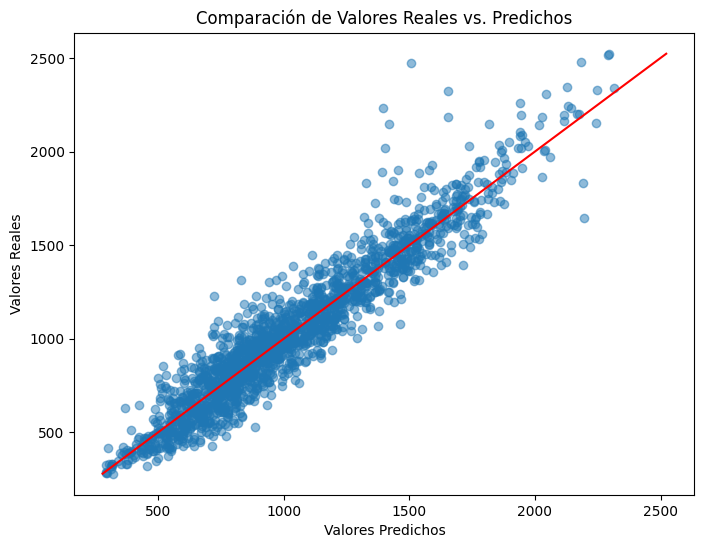

In [23]:
plot_predictions_vs_actual(y_test, y_pred)

### EXTRA: 

Busca en Internet o pregúntale a tu AI preferida, cómo se graba un modelo en disco y gúardalo en "./models/o3_pred" con la extesión apropiada.